In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO

import pdb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ----- LOAD DATA -----
# see 240811_pipeline_plottingCDFs for construction of this file
data = pd.read_csv('all_annotations.csv')

In [3]:
# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

# set hue order
ho = ['WT','Het']

In [4]:
# ----- DEFINE FUNCTIONS -----

def bin_and_cume(data,assayLen,t):
    '''Bin data in 0.1s bins and then rebin into bins of t sec length.'''
    bind = make_bins_from_DF(data,assayLen) # tabulate data in 0.1s bins
    usebins = make_arbitrary_bins(assayLen,t) # generate list of edges for larger bins
    # sum up positive bins from initial cut to rebin
    rebin = bind.groupby([bind.pair_tag,pd.cut(bind.bins,usebins,labels=usebins[1:])])['data'].sum().reset_index()
    rebin['data']=rebin.data/10
    gtlist = bind.groupby(['pair_tag'])['GT'].apply(lambda x: np.unique(x)[0]).reset_index()
    sexlist = bind.groupby(['pair_tag'])['sex'].apply(lambda x: np.unique(x)[0]).reset_index()
    numlist = bind.groupby(['pair_tag'])['pair_number'].apply(lambda x: np.unique(x)[0]).reset_index()
    metatab = pd.merge(gtlist, sexlist, on='pair_tag', how='outer')
    metatab = pd.merge(metatab,numlist,on='pair_tag',how='outer')
    binmeta = pd.merge(rebin,metatab,on='pair_tag',how='outer')
    binmeta['cumes'] = binmeta.groupby(['pair_tag']).data.cumsum()
    binmeta['totals'] = binmeta.groupby(['pair_tag']).data.transform('sum')
    binmeta['cumes_frac'] = binmeta.cumes/binmeta.totals
    return binmeta

def make_arbitrary_bins(assaylen,stepsize):
    assaylen = 1800
    nrsteps = int((assaylen)/stepsize)
    bins = np.linspace(0, 1800, num=nrsteps+1)
    return bins

def make_bins_from_DF(df,assaylen):

    allpairs = np.unique(df.pair_tag)
    
    stepsize = 0.1
    nrsteps = int((assaylen)/stepsize)
    bins = np.linspace(0, assaylen-stepsize, num=nrsteps)
    nrbins = len(bins)

    for j,pair in enumerate(allpairs):
        thisdf = df[df.pair_tag==pair]
        gt = np.unique(thisdf.GT)[0]
        sex = np.unique(thisdf.sex)[0]
        try:
            pn = np.unique(thisdf.pair_num)[0]
        except:
            pn = np.unique(thisdf.pair)[0]
        thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
        thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
        startsl = thisdf.starts_idx.to_list()
        endsl = thisdf.ends_idx.to_list()
        blankbins = np.zeros((len(bins,)))
        for i,start in enumerate(startsl):
            blankbins[int(start):int(endsl[i])] = 1
        GTs = [gt]*nrsteps
        sexes = [sex]*nrsteps
        PTs = [pair]*nrsteps
        pairnr = [pn]*nrsteps
        bindat = {'bins': bins, 'data': blankbins, 'sex':sexes,'GT':GTs,'pair_tag':PTs,'pair_number':pairnr}
        bindf = pd.DataFrame(data=bindat) 

        if j==0:
            collbins = bindf
        else:
            collbins = pd.concat([collbins,bindf])
  
    collbins['raw_cumes'] = collbins.groupby('pair_tag').data.cumsum()/10
    collbins['totals'] = collbins.groupby('pair_tag')['data'].transform('sum')/10
    collbins['cumes_behav_frac'] = collbins.raw_cumes/collbins.totals
        
    return collbins

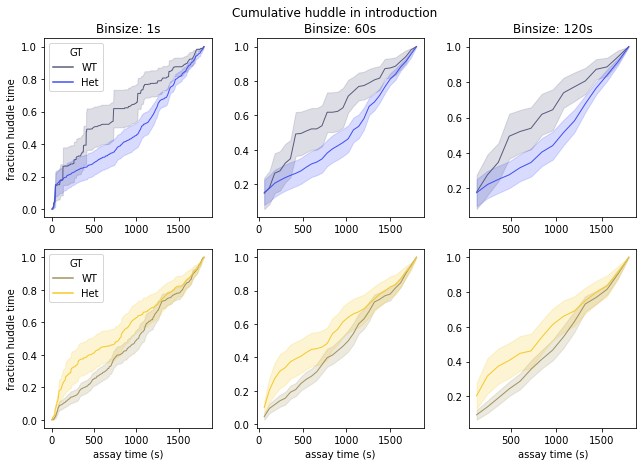

In [22]:
assay = 'introduction'
behavior = 'huddle'
bins = [1,60,120]
nrows = 2
ncols = len(bins)

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'Cumulative {behavior} in {assay}', y=1.04)

for i,bsize in enumerate(bins):
    binned = bin_and_cume(introhuddles,1800,bsize)
    
    # plot males
    g = sns.lineplot(
        data=binned[binned.sex=='M'],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=mpal,hue_order=ho,
        ax = ax[0,i],
    )
    
    # plot females
    h = sns.lineplot(
        data=binned[binned.sex=='F'],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=fpal,hue_order=ho,
        ax = ax[1,i],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[0,i].set_title(f'Binsize: {bsize}s')
    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
        g.get_legend().remove()
        h.get_legend().remove()
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        